In [172]:
# import sys
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download ru_core_news_sm
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 1.7/1.7 MB 2.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 92.7/92.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136904 sha256=fe81c06cd65807e8842586d744a191ddb81a00882b791229b554b555b70bcda6
  Stored in directory: C:\Users\User\Documents\TEMP\pip-ephem-wheel-cache-p4dfx384\wheels\62\73\dd\e1723cb4dfe5b31bf4719e640a6f9a28f488225e0af46a3514
Successfully built pyLDA


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: c:\users\user\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip


In [187]:
import json # обработка json файлов
import pandas as pd # работа с pandas DataFrame
import numpy as np # для работы с числами и последовательностями (финальный вывод)
import matplotlib.pyplot as plt # вывод графиков
import re # регулярные выражения для обработки статей
import stop_words # стоп-слова

import warnings # выключение отображение warning-ов
warnings.filterwarnings('ignore')  

In [1]:
article_filename = "articles.json" # путь до файла с полным сохранением статей
categories = ["entertainment", "auto", "sport", "health"] # рассматриваемые категории

In [36]:
articles = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        articles.append(json.loads(line))
data = pd.DataFrame(articles)
data.head()

,article_id,title,category,tags,text
0,https://www.nn.ru/text/entertainment/2023/01/1...,Кто такой цуцик и где раки зимуют? Попробуйте ...,entertainment,"Развлечения,Знания,История,Развлечения,Тест,Фр...","Если бы не было фразеологизмов, наша речь (а в..."
1,https://www.nn.ru/text/entertainment/2023/01/1...,Снова как мальчик: Филипп Киркоров резко помол...,entertainment,"Развлечения,Филипп Киркоров,Звезды,Шоу-бизнес","Редко кто может похвастаться тем, что после ка..."
2,https://www.nn.ru/text/entertainment/2023/01/1...,2023 — это колесница: каким будет год Черного ...,entertainment,"Развлечения,Гороскоп,Нумеролог,Прогноз нумерол...","Если присмотреться внимательнее, то можно обна..."
3,https://www.nn.ru/text/entertainment/2023/01/1...,Вам не решить: 10 советских задач в картинках ...,entertainment,"Развлечения,СССР,Интересный тест,Тест,Внимание...",Ставить опыты над возможностями человеческих п...
4,https://www.nn.ru/text/entertainment/2023/01/1...,Не только «Ёлки-9»: что больше всего приглянул...,entertainment,Развлечения,Wink представляет самые популярные фильмы и се...


# 1) Предобработка данных

# первый вариант (старый)

In [ ]:
import string # для обработки статей
import pymorphy2 # для проверки на "существование" слова

In [6]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [12]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)' , ' ', text) for text in corpus] # удаление неполных ссылок
# в статьях нет \n или \t

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub(' ', text) for text in corpus] # убираем пунктуацию

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub(' ', text) for text in corpus] # убираем цифры

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +' , ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

In [40]:
morph = pymorphy2.MorphAnalyzer()

corpus_tokens = [] # для токенов из строк
inds_to_drop = [] # статьи, что будут убраны

for i, sentence in enumerate(corpus):
    tmp_tokens = [] # временный массив с токенами
    sp = sentence.split() # разделяем строку по пробелам
    for word in sp: # проходим по словам в строке
        if word not in stop_words.get_stop_words('ru'): # если слова нет в списке стоп-слов для русского языка
            if morph.word_is_known(word): # проверяет, что слово есть в словаре
                tmp_tokens.append(word) # добавляем токен
    if len(tmp_tokens) > 0: # если после попытки токенизации строки получилось хоть сколько-то токенов, то записываем их в corpus_tokens
        corpus_tokens.append(tmp_tokens)
    else: # иначе - добавляем строку в дропы
        inds_to_drop.append(i)
        
print(len(corpus_tokens), len(inds_to_drop)) # в данном случае, все статьи были токенизированы

4057 0


In [53]:
data["text"][0]

'Если бы не было фразеологизмов, наша речь (а возможно, и вся жизнь) была бы куда скучнее. Но еще интереснее не просто пользоваться этими выражениями, но и знать, откуда они произошли и почему мы вообще так стали говорить. Узнать это мы и предлагаем вам прямо сейчас. И не бойтесь ошибиться — это тест не про исключительные знания, а про то, что нас окружает.   '

In [33]:
corpus[0]

'если бы не было фразеологизмов наша речь а возможно и вся жизнь была бы куда скучнее но еще интереснее не просто пользоваться этими выражениями но и знать откуда они произошли и почему мы вообще так стали говорить узнать это мы и предлагаем вам прямо сейчас и не бойтесь ошибиться это тест не про исключительные знания а про то что нас окружает'

In [42]:
print(corpus_tokens[0])

['фразеологизмов', 'речь', 'возможно', 'скучнее', 'интереснее', 'пользоваться', 'выражениями', 'знать', 'откуда', 'произошли', 'вообще', 'стали', 'говорить', 'узнать', 'предлагаем', 'прямо', 'бойтесь', 'ошибиться', 'тест', 'исключительные', 'знания', 'окружает']


# второй вариант (новый)

In [ ]:
import spacy # обработка текста + лемматизация слов (приведение к нормальной форме) + создание корпуса

In [29]:
nlp = spacy.load("ru_core_news_sm") # nlp (Natural Language Processing) - Объект Language с загруженным pipeline-ом (tok2vec, morphologizer, parser, senter, ner, attribute_ruler, lemmatizer)

In [98]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [122]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)', ' ', text) for text in corpus] # удаление неполных ссылок
# в статьях нет \n или \t

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub(' ', text) for text in corpus] # убираем цифры

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub(' ', text) for text in corpus] # убираем пунктуацию

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +', ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

In [123]:
docs = []
for text in corpus:
    docs.append(nlp(text)) # передача данных в pipeline Natural Language Processing

сохранение, так как предыдущий блок очень долго выполнялся

In [124]:
# import pickle
f = open(r'nlp_articles.pkl', 'wb') # сохранение в бинарном формате (1.5 ГИГАБАЙТА?!)
pickle.dump(docs, f)

In [125]:
f = open(r'nlp_articles.pkl', 'rb')
obj = pickle.load(f)
print(obj[0][0].is_stop) # проверка работы

True


In [126]:
data["text"][0]

'Если бы не было фразеологизмов, наша речь (а возможно, и вся жизнь) была бы куда скучнее. Но еще интереснее не просто пользоваться этими выражениями, но и знать, откуда они произошли и почему мы вообще так стали говорить. Узнать это мы и предлагаем вам прямо сейчас. И не бойтесь ошибиться — это тест не про исключительные знания, а про то, что нас окружает.   '

In [127]:
docs[0]

если бы не было фразеологизмов наша речь а возможно и вся жизнь была бы куда скучнее но еще интереснее не просто пользоваться этими выражениями но и знать откуда они произошли и почему мы вообще так стали говорить узнать это мы и предлагаем вам прямо сейчас и не бойтесь ошибиться это тест не про исключительные знания а про то что нас окружает

In [165]:
texts, article, skl_texts = [], [], []
additional_stop_words = stop_words.get_stop_words('ru')
# texts - массив лемматизированных статей (массив из массивов лемм для статей)
# article - массив лемм в одной статье (зануляется при окончании рассматриваемой статьи)
# skl_texts - массив текстов из лемм
for text in docs:
    for idx, w in enumerate(text): # проходимся по всем словам из выбранной статьи
        # если это не стоп-слово и не знак препинания (+ число, конец строки), добавляем его в нашу статью!
        if not w.is_stop and not w.is_punct and not w.like_num and not w.text in additional_stop_words: # w.text - для взятия слова
            # добавляем лематизированную версию слова
            article.append(w.lemma_)
        # если это новая строка, это означает, что мы находимся в нашем следующем документе
        if idx == (len(text) - 1):
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []

In [166]:
print(texts[0])

['фразеологизм', 'речь', 'скучный', 'интересный', 'пользоваться', 'выражение', 'знать', 'произойти', 'говорить', 'узнать', 'предлагать', 'прямо', 'бояться', 'ошибиться', 'тест', 'исключительный', 'знание', 'окружать']


In [167]:
print(skl_texts[0])

фразеологизм речь скучный интересный пользоваться выражение знать произойти говорить узнать предлагать прямо бояться ошибиться тест исключительный знание окружать


# Объединение слов в n-граммы

In [ ]:
import gensim # для объединения слов в n-граммы
from gensim.corpora import Dictionary # для создания словаря

In [141]:
bigram = gensim.models.Phrases(texts) # обучение модели нахождения n-грамм

In [136]:
print(texts[-1], "\n\n", bigram[texts[-1]])

['октябрь', 'отправить', 'космический', 'станция', 'актриса', 'юлия', 'пересильд', 'режиссёр', 'клим', 'шипенко', 'орбита', 'снять', 'часть', 'российский', 'фильм', 'вызов', 'замысел', 'автор', 'фильм', 'пересильд', 'сыграть', 'врач', 'вынуждена', 'полететь', 'мкс', 'спасти', 'жизнь', 'космонавт', 'полёт', 'киноэкипажа', 'орбита', 'земля', 'космический', 'среда', 'вызвать', 'неоднозначный', 'реакция', 'рассказать', 'доктор', 'питер', 'психолог', 'анна', 'юсупов', 'непрофессионал', 'полететь', 'космос', 'последний', 'месяц', 'космос', 'полететь', 'столько', 'непрофессионал', 'российский', 'киноэкипаж', 'американский', 'экипаж', 'илона', 'маска', 'летать', 'предыдущий', 'история', 'космонавтика', 'дело', 'абсолютно', 'нормальный', 'закономерный', 'развитие', 'космический', 'отрасль', 'космос', 'становиться', 'доступный', 'человек', 'говорить', 'анна', 'юсупов', 'вызывать', 'вопрос', 'сделать', 'дневный', 'полёт', 'актриса', 'режиссёр', 'орбита', 'земля', 'стоить', 'российский', 'бюджет',

In [137]:
texts_v2 = [bigram[line] for line in texts] # создаём массив лемм для статей с использованием биграммами (во многом он остался схож с обычным texts)

In [142]:
dictionary = Dictionary(texts_v2) # создаём словарь (слова будут в нём не по порядку)

In [148]:
print(dictionary)

Dictionary<83365 unique tokens: ['бояться', 'выражение', 'говорить', 'жизнь', 'знание']...>


In [152]:
print(dictionary[2]) # вывод слова по id
print(dictionary.token2id["говорить"]) # вывод id, под которым слово записано в словаре

говорить
2


In [153]:
corpus = [dictionary.doc2bow(text) for text in texts_v2] # преобразовывание статей в формат bag-of-words (BoW)

In [155]:
corpus[0][0:10] # возвращает: (id слова в словаре, сколько раз оно встречается)

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

# 2) Использование моделей

## LDA в gensim:

In [179]:
from gensim.models import LdaModel, CoherenceModel # модель + метрика оценивания

In [159]:
chunksize = 2000 # Количество документов, которые будут использоваться в каждом блоке обучения
passes = 20 # Количество проходов по корпусу во время обучения
iterations = 400 # Максимальное количество итераций по корпусу при выводе тематического распределения корпуса
eval_every = None  # Don't evaluate model perplexity, takes too much time.

ldamodel = LdaModel(corpus=corpus, # передаваемый поток документов
                    num_topics=10, # Количество запрошенных скрытых тем, которые необходимо извлечь из учебного корпуса.
                    id2word=dictionary, # Mapping id к словам (словарь)
                    chunksize=chunksize, # Количество документов, которые будут использоваться в каждом блоке обучения
                    alpha='auto', # априорное убеждение в распространении тем по документам
                    eta='auto', # априорное убеждение в распределении слов по темам
                    iterations=iterations, # Максимальное количество итераций по корпусу при выводе тематического распределения корпуса
                    passes=passes, # Количество проходов по корпусу во время обучения
                    eval_every=eval_every)

In [160]:
ldamodel.show_topics()  # Вывод тем для LDA модели

[(0,
  '0.018*"блюдо" + 0.013*"ресторан" + 0.009*"повышение_температура" + 0.007*"рубль" + 0.007*"готовить" + 0.007*"медработник" + 0.007*"доставка" + 0.007*"глава_минздрав" + 0.006*"еда" + 0.006*"заказать"'),
 (1,
  '0.009*"врач" + 0.008*"антибиотик" + 0.007*"рак" + 0.007*"женщина" + 0.006*"человек" + 0.006*"проблема" + 0.006*"год" + 0.006*"раз" + 0.005*"организм" + 0.005*"стоить"'),
 (2,
  '0.011*"печень" + 0.009*"тест_система" + 0.006*"пенсионный" + 0.005*"форвард" + 0.005*"лекарственный" + 0.004*"сегодня" + 0.004*"жировой_болезнь" + 0.004*"хк_торпедо" + 0.004*"забивать" + 0.003*"жидкость"'),
 (3,
  '0.014*"человек" + 0.011*"россия" + 0.009*"страна" + 0.007*"говорить" + 0.007*"регион" + 0.006*"ситуация" + 0.006*"новый" + 0.006*"нерабочий_день" + 0.006*"вакцинация" + 0.005*"инфекция"'),
 (4,
  '0.009*"год" + 0.006*"нижний_новгород" + 0.006*"команда" + 0.005*"игра" + 0.005*"матч" + 0.004*"время" + 0.004*"россия" + 0.004*"новый" + 0.003*"пройти" + 0.003*"место"'),
 (5,
  '0.015*"органи

## LDA в sklearn:

In [161]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [169]:
def display_topics(model, feature_names, no_top_words): # функция для вывода самых главных тем текста (с наибольшим значением)
    for topic_idx, topic in enumerate(model.components_): # разбиение на номер текста/темы текста
        print ("Topic %d:" % (topic_idx)) # номер текста
        print (" ".join([feature_names[i] # выводим имена тем по отсортированным индексам
                        for i in topic.argsort()[:-no_top_words - 1:-1]])) # сортируем индексы по возрастанию важности темы

no_features = 1000 # сколько самых частых слов будет использовано (slice словаря по частоте встречи слов в корпусе)
# можно передать словарь

# LDA can only use raw term counts because it is a probabilistic graphical model
# tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features) # tf векторизация
tf = tf_vectorizer.fit_transform(skl_texts)
tf_feature_names = tf_vectorizer.get_feature_names_out()

no_topics = 10 # число предсказываемых тем

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10 # число тем для вывода

display_topics(lda, tf_feature_names, no_top_words) # вывод для модели LDA

Topic 0:
месяц знак новый работа ноябрь сентябрь балл прийтись представитель рак
Topic 1:
матч команда сборная игра россия счёт чемпионат минута игрок болельщик
Topic 2:
нижний новгород нижегородский нижегородец город текст пройти клуб новость матч
Topic 3:
фильм новый сериал проект история главный wink зритель хороший герой
Topic 4:
автомобиль рубль машина россия модель новый рынок компания цена завод
Topic 5:
цена рубль стоимость узнать сайт программа покупка купить работать новый
Topic 6:
машина автомобиль дорога двигатель система новый задний место мотор рубль
Topic 7:
ребёнок человек врач говорить женщина знать делать работать сделать рассказывать
Topic 8:
водитель вакцина случай коронавирус вакцинация регион область прививка штраф россия
Topic 9:
врач человек заболевание пациент препарат случай болезнь вирус организм симптом


## 3) Визуализация

In [173]:
import pyLDAvis.gensim_models

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\past\types\oldstr.py:23: DeprecationWarning: invalid escape sequence \d
  """
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [174]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.035540  0.030335       1        1  41.763171
6     -0.108414  0.116767       2        1  13.451455
7      0.049981  0.109714       3        1  12.833672
8     -0.218106  0.039175       4        1   8.922168
9      0.034820  0.065959       5        1   8.432521
3     -0.189331 -0.091059       6        1   6.799730
1     -0.016972  0.111749       7        1   3.460970
5     -0.065090 -0.306900       8        1   2.379808
0      0.277848 -0.043688       9        1   1.241706
2      0.270805 -0.032051      10        1   0.714799, topic_info=                 Term         Freq        Total Category  logprob  loglift
700           человек  6004.000000  6004.000000  Default  30.0000  30.0000
3037       автомобиль  3248.000000  3248.000000  Default  29.0000  29.0000
1824  нижний_новгород  2960.000000  2960.000000  Default  28.0000  28.0000
2605           машина  2836.000000  2836.000000  Default  27.0000  27.0000
9766         водитель  1671.000000  1671.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
3140      неожиданный    18.634663   122.852085  Topic10  -6.1140   3.0550
206         подробный    19.493103   252.389951  Topic10  -6.0689   2.3800
162          название    18.801592   311.451490  Topic10  -6.1050   2.1336
694           хороший    18.708023  2441.520525  Topic10  -6.1100   0.0695
1929          картина    18.322145   389.192367  Topic10  -6.1309   1.8850

[676 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
82483      6  0.996345        ay
19795      4  0.518820     covid
19795      6  0.283579     covid
19795      8  0.194960     covid
41337      3  0.993587    duster
...      ...       ...       ...
1802       3  0.281923  являться
1802       4  0.163697  являться
1802       5  0.255650  являться
1802       7  0.106100  являться
47659      9  0.975604        ям

[1460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 8, 9, 10, 4, 2, 6, 1, 3])

### Тематическая согласованность (Topic Coherence)
Чем выше значение когерентности, тем лучше модель

In [180]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts_v2, dictionary=dictionary, window_size=10).get_coherence() # рассчитывает согласованность тем для topic models

In [188]:
def evaluate_bar_graph(coherences, indices): # функция для вывода bar графика
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices) # проверка на равное число элементов
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

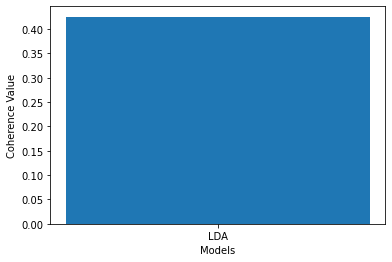

In [189]:
evaluate_bar_graph([lda_coherence],
                   ['LDA'])